In [63]:
import tensorflow as tf

In [64]:
import numpy as np
import pandas as pd

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, load_model
from keras.layers import Activation, Dense, Input, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import InceptionV3

In [66]:
disease_type = ['Healthy','Early_blight','Late_blight']
data_path = 'E:/Crop_disease/dataset/potato/'
train_dir = os.path.join(data_path)

In [67]:
os.listdir(train_dir)

['Early_blight', 'healthy', 'Late_blight']

In [68]:
train_data = []
for id, sp in enumerate(disease_type):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

In [69]:
train.head(500)

,File,DiseaseID,Disease Type
0,Healthy/00fc2ee5-729f-4757-8aeb-65c3355874f2__...,0,Healthy
1,Healthy/03da9931-e514-4cc7-b04a-8f474a133ce5__...,0,Healthy
2,Healthy/04481ca2-f94c-457e-b785-1ac05800b7ec__...,0,Healthy
3,Healthy/046641c1-f837-49eb-b5f2-4109910a027c__...,0,Healthy
4,Healthy/07dfb451-4378-49d1-b699-33a5fc49ff07__...,0,Healthy
...,...,...,...
495,Healthy/IMG20230103123418.jpg,0,Healthy
496,Healthy/IMG20230103123425.jpg,0,Healthy
497,Healthy/IMG20230103123435.jpg,0,Healthy
498,Healthy/IMG20230103123441.jpg,0,Healthy


In [70]:
len(train)

3293

In [71]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,Late_blight/fb9dc049-ec76-4502-9a11-13fb62a26e...,2,Late_blight
1,Late_blight/faf67766-afc0-4f41-af0b-a3971fe325...,2,Late_blight
2,Late_blight/e9cc84b7-fc38-4e65-a129-c7a63df767...,2,Late_blight
3,Early_blight/IMG20230103104037.jpg,1,Early_blight
4,Late_blight/36d2885d-0bc7-4346-8a13-383e1533a6...,2,Late_blight


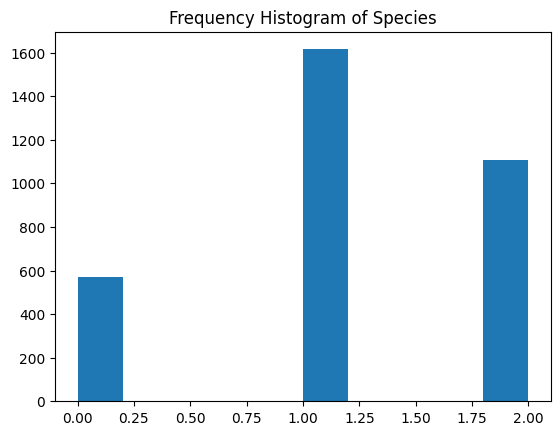

<Figure size 1200x1200 with 0 Axes>

In [72]:
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

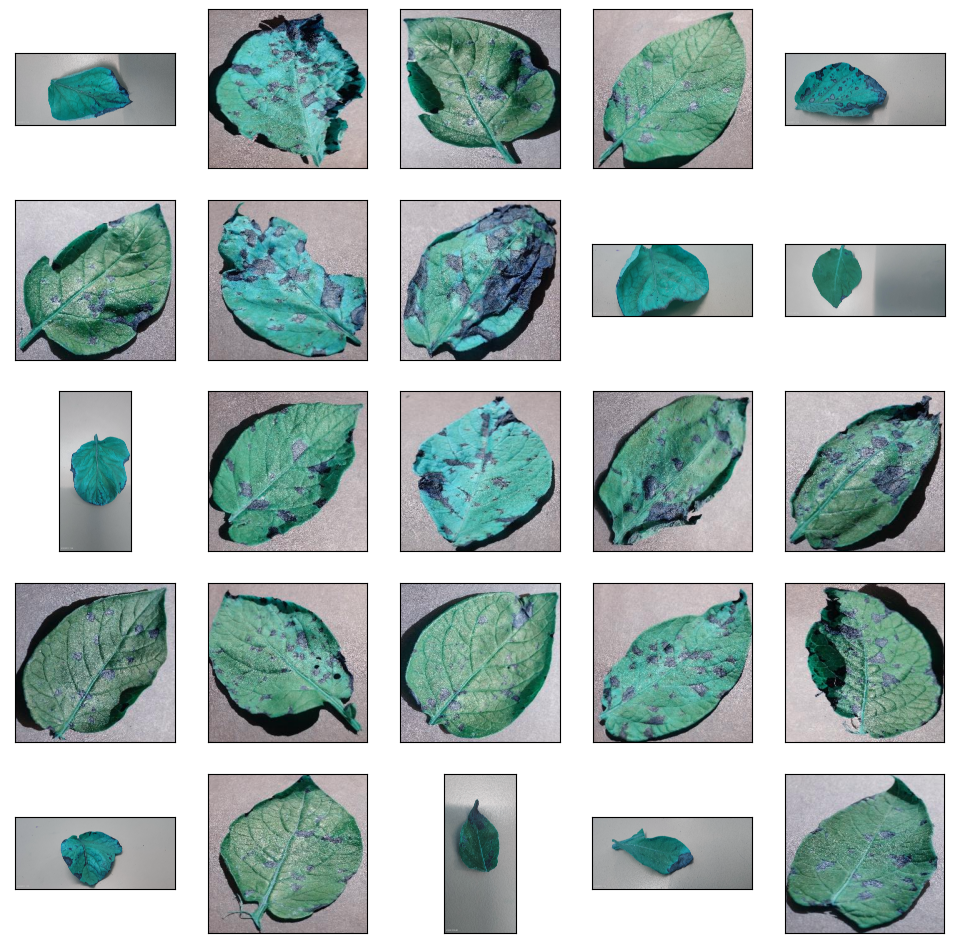

In [73]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_path, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('Early_blight', 5, 5)

In [74]:
IMAGE_SIZE = 320

def read_image(filepath):
    return cv2.imread(os.path.join(data_path, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [75]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

3293it [03:07, 17.59it/s]


Train Shape: (3293, 320, 320, 3)


In [76]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=3)

In [77]:
# BATCH_SIZE = 16
#train:val:test = 8:1:1
# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

In [78]:
len(X_train)

2634

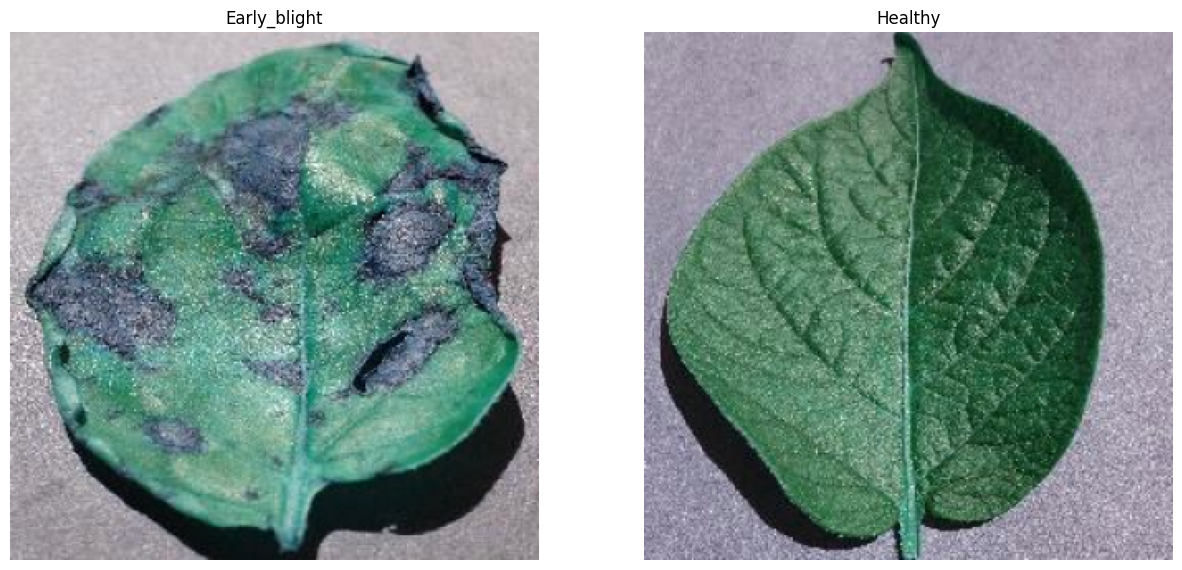

In [79]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
for i in range(2):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_type[np.argmax(Y_train[i])])

In [86]:
# EPOCHS = 30
SIZE=320
N_ch=3

In [87]:
from collections import Counter
print(Counter(train['Disease Type']))

Counter({'Early_blight': 1615, 'Late_blight': 1106, 'Healthy': 572})


In [88]:
class_weights = {0:1615/3293, 1:572/3293, 2:1106/3293}

In [89]:
model = Sequential()
          
# 1st Convolutional Layer
model.add(Conv2D(filters = 96, input_shape = (320,320,3), kernel_size = (11,11), strides = (4,4), padding = 'valid'))
model.add(Activation('relu'))
# Batch Normalisation before passing it to the next layer
model.add(BatchNormalization())
# Pooling Layer
model.add(MaxPool2D(pool_size = (3,3), strides = (2,2), padding = 'valid'))

# 2nd Convolutional Layer
model.add(Conv2D(filters = 256, kernel_size = (5,5), strides = (1,1), padding = 'same'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())
# Pooling Layer
model.add(MaxPool2D(pool_size = (3,3), strides = (2,2), padding = 'valid'))

# 3rd Convolutional Layer
model.add(Conv2D(filters = 384, kernel_size = (3,3), strides = (1,1), padding = 'same'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())
# Dropout
model.add(Dropout(0.5))

# 4th Convolutional Layer
model.add(Conv2D(filters = 384, kernel_size = (3,3), strides = (1,1), padding = 'same'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())
# Dropout
model.add(Dropout(0.5))

# 5th Convolutional Layer
model.add(Conv2D(filters = 256, kernel_size = (3,3), strides = (1,1), padding = 'same'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())
# Pooling Layer
model.add(MaxPool2D(pool_size = (3,3), strides = (2,2), padding = 'valid'))
# Dropout
model.add(Dropout(0.5))

# Passing it to a dense layer
model.add(Flatten())

# 1st Dense Layer
model.add(Dense(4096, input_shape = (320*320*3,)))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.25))
# Batch Normalisation
model.add(BatchNormalization())

# 2nd Dense Layer
model.add(Dense(4096))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.5))
# Batch Normalisation
model.add(BatchNormalization())

# 3rd Dense Layer
model.add(Dense(1000))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.5))
# Batch Normalisation
model.add(BatchNormalization())

# Output Layer
model.add(Dense(N_ch))
model.add(Activation('softmax'))

# Get the model summary.
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_62 (Conv2D)          (None, 78, 78, 96)        34944     
                                                                 
 activation_78 (Activation)  (None, 78, 78, 96)        0         
                                                                 
 batch_normalization_81 (Bat  (None, 78, 78, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 38, 38, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_63 (Conv2D)          (None, 38, 38, 256)       614656    
                                                                 
 activation_79 (Activation)  (None, 38, 38, 256)     

In [100]:
aug = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2, 
    zoom_range = 0.2,
    horizontal_flip = True, 
    fill_mode = "nearest")

In [101]:
opt = tf.keras.optimizers.Adam(lr = 0.002)
model.compile(loss="categorical_crossentropy", optimizer = opt,metrics = ["accuracy"])
print("[INFO] Training network...")

# Train
checkpoint = ModelCheckpoint("AlexNet.h5", monitor = 'accuracy', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'auto', period = 1)

history = model.fit(
    aug.flow(X_train, Y_train, batch_size = 64),
    validation_data = (X_val, Y_val),
    steps_per_epoch = len(X_train) // 64,
    callbacks = [checkpoint],
    epochs = 30,
    verbose=1 )

[INFO] Training network...


C:\Users\User1\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/30
41/41 [==============================] - ETA: 0s - loss: 0.2067 - accuracy: 0.9230
Epoch 1: accuracy improved from -inf to 0.92296, saving model to AlexNet.h5
41/41 [==============================] - 63s 1s/step - loss: 0.2067 - accuracy: 0.9230 - val_loss: 1.0109 - val_accuracy: 0.8270
Epoch 2/30
41/41 [==============================] - ETA: 0s - loss: 0.1828 - accuracy: 0.9311
Epoch 2: accuracy improved from 0.92296 to 0.93113, saving model to AlexNet.h5
41/41 [==============================] - 59s 1s/step - loss: 0.1828 - accuracy: 0.9311 - val_loss: 11.1743 - val_accuracy: 0.5144
Epoch 3/30
41/41 [==============================] - ETA: 0s - loss: 0.1720 - accuracy: 0.9389
Epoch 3: accuracy improved from 0.93113 to 0.93891, saving model to AlexNet.h5
41/41 [==============================] - 63s 2s/step - loss: 0.1720 - accuracy: 0.9389 - val_loss: 1.0394 - val_accuracy: 0.8558
Epoch 4/30
41/41 [==============================] - ETA: 0s - loss: 0.1480 - accuracy: 0.9475
Ep

41/41 [==============================] - ETA: 0s - loss: 0.0919 - accuracy: 0.9689
Epoch 30: accuracy did not improve from 0.97276
41/41 [==============================] - 54s 1s/step - loss: 0.0919 - accuracy: 0.9689 - val_loss: 0.1623 - val_accuracy: 0.9499


In [102]:
# def build_alexnet():
#     alexnet = AlexNet()
    
#     input = Input(shape=(SIZE, SIZE, N_ch))
#     x = Conv2D(3, (3, 3), padding='same')(input)
    
#     x = alexnet(x)
    
#     x = GlobalAveragePooling2D()(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.5)(x)
#     x = Dense(256, activation='relu')(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.5)(x)

#     # multi output
#     output = Dense(3,activation = 'softmax', name='root')(x)
 

#     # model
#     model = Model(input,output)
    
#     optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
#     model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#     model.summary()
    
#     return model

In [103]:
# model = build_alexnet()
# annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
# checkpoint = ModelCheckpoint('potato_alexnet.h5', verbose=1, save_best_only=True)
# # Generates batches of image data with data augmentation
# datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
#                         width_shift_range=0.2, # Range for random horizontal shifts
#                         height_shift_range=0.2, # Range for random vertical shifts
#                         zoom_range=0.2, # Range for random zoom
#                         horizontal_flip=True, # Randomly flip inputs horizontally
#                         vertical_flip=True) # Randomly flip inputs vertically

# datagen.fit(X_train)
# # Fits the model on batches with real-time data augmentation
# hist = model.fit(datagen.flow(X_train, Y_train, batch_size=32),
#                steps_per_epoch=X_train.shape[0] // 32,
#                epochs=30,
#                verbose=2,
#                callbacks=[annealer, checkpoint],
#                validation_data=(X_val, Y_val),
#                class_weight=class_weights)

In [104]:
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

21/21 [==============================] - 1s 39ms/step - loss: 0.1623 - accuracy: 0.9499
Final Loss: 0.16228218376636505, Final Accuracy: 0.949924111366272


21/21 [==============================] - 1s 32ms/step


Text(0.5, 192.58159722222217, 'Predicted')

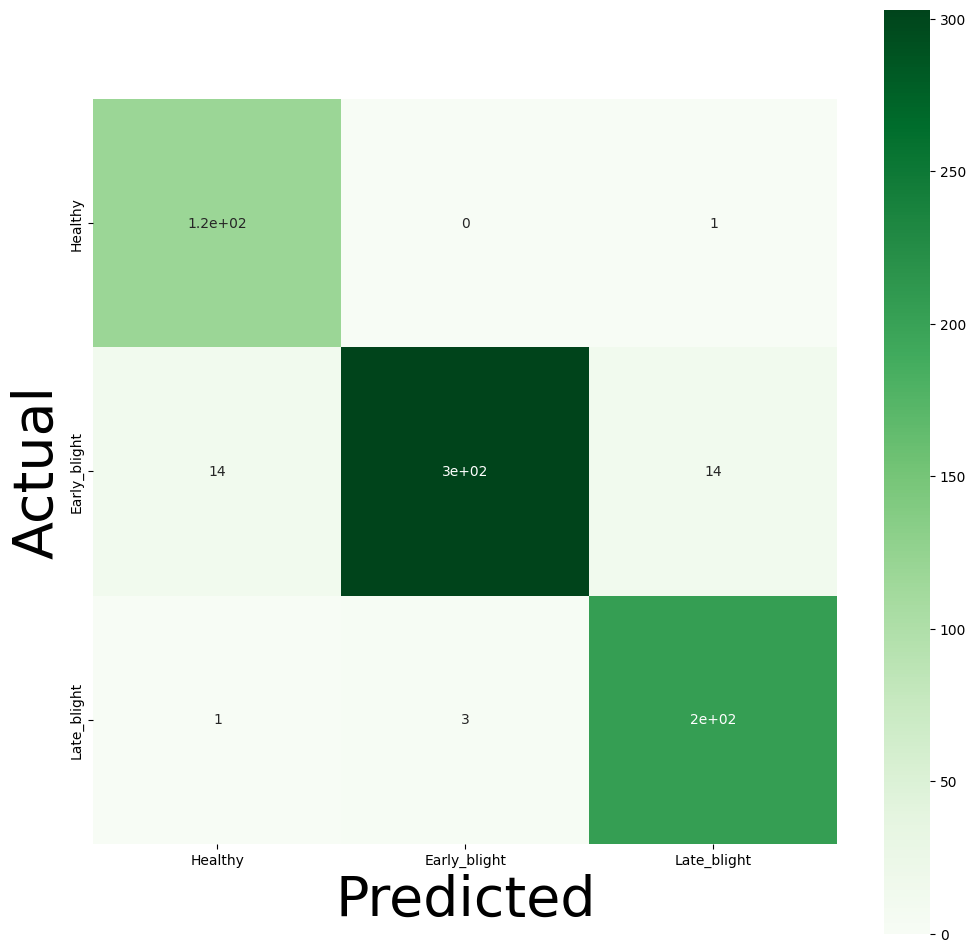

In [105]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_type, yticklabels=disease_type)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

In [106]:
from sklearn.metrics import classification_report

In [107]:
print(classification_report(Y_true, Y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       120
           1       0.99      0.92      0.95       331
           2       0.93      0.98      0.96       208

    accuracy                           0.95       659
   macro avg       0.94      0.96      0.95       659
weighted avg       0.95      0.95      0.95       659



In [108]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [109]:
print(f1_score(Y_true, Y_pred, average='weighted'))

0.9500415103336408


In [110]:
print(precision_score(Y_true, Y_pred, average='weighted'))

0.9530735823936616


In [111]:
print(recall_score(Y_true, Y_pred, average='weighted'))

0.9499241274658573


In [112]:
# # accuracy plot 
# plt.plot(hist.history['accuracy'])
# plt.plot(hist.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [113]:
# # loss plot
# plt.plot(hist.history['loss'])
# plt.plot(hist.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()